In [ ]:
# Skip if not run in Google Colab

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

# Text preprocessing


## Import module

In [1]:
import pandas as pd
import string
import re
# import NLP lib and its stopwords module
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
# stopwords[10:20]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Veera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

Below is an example data

In [2]:
# Example data
df = pd.read_excel('./notebooks data/notebooks-data.xlsx')
df = df.drop(columns='Notebook').rename(columns={"Markdown content": "markdown"})
df['markdown']

0      ## General information\n\nIn this kernel I wor...
1                                    Importing libraries
2      ## Functions used in this kernel\nThey are in ...
3      ## Data loading and overview\n\nData is separa...
4      So we have two medium-sized datasets with a lo...
                             ...                        
119    As expected, the most important features are t...
120    We see that all four of our hand-engineered fe...
121    This submission should score about 0.735 on th...
122    Again, we see tha some of our features made it...
123    This model scores about 0.754 when submitted t...
Name: markdown, Length: 124, dtype: object

## Preprocessing function

1. Preprocess text - Lowercase text, remove any punctuation, and remove newline
2. Remove hyperlink - Remove hyperlinks
3. Remove tags - Remove HTML tags in the text
4. Remove stopwords - Remove stopwords in English langauge from the text
5. Tokenization - Tokenize the text into a list of words

In [3]:
def preprocess_text(text):
  text = text.lower() # lowercase the text
  text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text).strip() # replace punctuation with ' '(space)
  text = " ".join(text.split()) # remove the excess spaces and newlines
  return text

def remove_hyperlink(text):
  text = re.sub(r'https?://\S+', "", text)
  text = " ".join(re.sub(r'https?://\S+', "", text).split())
  return text

def remove_tags(text):
  return re.sub(r"<.*?>", " ", text)

def remove_stopwords(text):
  output = "".join([i for i in text if i not in stopwords])
  return output
  
def tokenization(text):
  return re.split('W+', text)

6. Stemming

In [4]:
# Import for stemming function
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming(text):
  stemmed_text = " ".join([porter_stemmer.stem(word) for word in text.split()])
  return stemmed_text


7. Lemmatization

In [5]:
# Import for NLTK modules
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
nltk.download('omw-1.4')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text, type='nltk'):
  lemmatized_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text.split()])
  return lemmatized_text


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Veera\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Veera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Uncomment below to use spaCy lemmatization module

In [9]:
# # Import for spaCy modules
# ## Install spaCy (run in terminal/prompt)
# import sys
# !{sys.executable} -m pip install spacy
# ## Download spaCy's  'en' Model
# !{sys.executable} -m spacy download en

# ## Import spaCy
# import spacy
# spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatizer_spacy(text):
#   spacy_doc = spacy_nlp(text)
#   lemmatized_text = " ".join([token.lemma_ for token in spacy_doc])
#   return lemmatized_text

In [6]:
# Assign preprocesssed data to DataFrame

df['preprocessed_text'] = df['markdown'].map(remove_tags).map(remove_hyperlink).map(preprocess_text).map(tokenization).map(remove_stopwords).map(stemming).map(lemmatizer) 
df['preprocessed_text']

0      gener inform in thi kernel i work with ieee fr...
1                                         import librari
2      function use in thi kernel they are in the hid...
3      data load and overview data is separ into two ...
4      so we have two medium size dataset with a lot ...
                             ...                        
119    a expect the most import featur are those deal...
120    we see that all four of our hand engin featur ...
121    thi submiss should score about 0 735 on the le...
122    again we see tha some of our featur made it in...
123    thi model score about 0 754 when submit to the...
Name: preprocessed_text, Length: 124, dtype: object

# AgglomerativeCluster Model

## Import modules

In [7]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
# import urllib as urllib2
from urllib.request import urlopen

from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [8]:
# Please select whether you use regular Python or Anaconda package management
import sys
!{sys.executable} -m pip install mlxtend

# !conda install --yes --prefix {sys.prefix} numpy

# # If the package not found, make sure to enable conda-forge channel 
# !conda config --add channels conda-forge
# !conda config --set channel_priority strict

from mlxtend.preprocessing import DenseTransformer


## Building model

In [9]:

def densedVectorizing(series: pd.Series(dtype=str)):
    """
    Vectorize the text data and make them into densed matrix.
    """
    tfidf = TfidfVectorizer()
    series_vectorized = tfidf.fit_transform(series)
    # transformer = FunctionTransformer(lambda x: x.todense(), accept_sparse=True) # Using FunctionTransformer as densified function
    transformer = DenseTransformer() # Using mlxtend DenseTransformer function
    return transformer.transform(series_vectorized)

In [10]:
vectorized_data = densedVectorizing(df['preprocessed_text'])

print('There are total of {} feature(s) in the data\nand total of {} observations(number of data).'.format(vectorized_data.shape[1], vectorized_data.shape[0]))

There are total of 1009 feature(s) in the data
and total of 124 observations(number of data).


In [30]:
# Construct a pipeline: TF-IDF -> Sparse to Dense -> Clustering
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    # FunctionTransformer(lambda x: x.todense(), accept_sparse=True), # Using FunctionTransformer as densified function
    DenseTransformer(), # Using mlxtend DenseTransformer function
    AgglomerativeClustering(n_clusters=10, linkage='ward')  # Use average linkage
    # AgglomerativeClustering()
)

pipeline = pipeline.fit(df['preprocessed_text'])

In [31]:
pipeline.named_steps

{'tfidfvectorizer': TfidfVectorizer(stop_words='english'),
 'densetransformer': DenseTransformer(),
 'agglomerativeclustering': AgglomerativeClustering(n_clusters=10)}

In [32]:
model = pipeline.named_steps['agglomerativeclustering']

## Assign the data to cluster

Using `fit_predict` method of the model to cluster the data, then append them to DataFrame along with their corresponding text data. 

In [33]:
clustered_data = model.fit_predict(densedVectorizing(df['preprocessed_text']))
mapped = np.column_stack((model.labels_, df['preprocessed_text']))

cluster_df = pd.DataFrame(mapped).rename(columns={0: 'cluster-assignment', 1: 'text-data'})
print(cluster_df.head())
cluster_df.to_csv('output-cluster.csv', index=False, )

  cluster-assignment                                          text-data
0                  1  gener inform in thi kernel i work with ieee fr...
1                  1                                     import librari
2                  1  function use in thi kernel they are in the hid...
3                  1  data load and overview data is separ into two ...
4                  0  so we have two medium size dataset with a lot ...


## Visualization the Dendogram with SciPy

In [26]:
# Original source: https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage


In [27]:
# Implicit interface dendogram function

def plot_dendrogram(model, **kwargs):
  # Children of hierarchical clustering
  children = model.children_

  # Distances between each pair of children
  # Since we don't have this information, we can use a uniform one for plotting
  distance = np.arange(children.shape[0])

  # The number of observations contained in each cluster level
  no_of_observations = np.arange(2, children.shape[0] + 2)

  # Create linkage matrix and then plot the dendrogram
  linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=8, orientation="left", **kwargs)
  # , labels=df.index
  show()

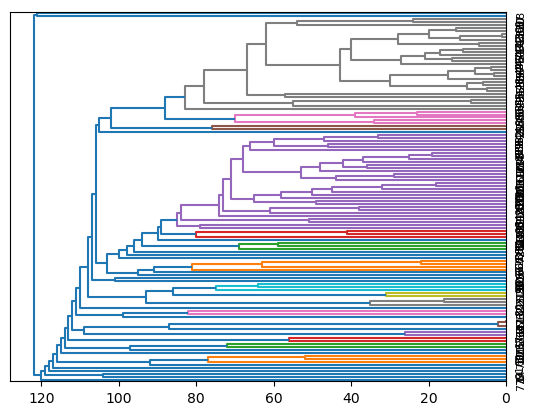

In [28]:
plot_dendrogram(model, labels=df['preprocessed_text'].index)

In [29]:
# Create my own figure
def plot_dendrogram_mpl(model, **kwargs):
  children = model.children_
  distance = np.arange(children.shape[0])
  no_of_observations = np.arange(2, children.shape[0] + 2)

  linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

  fig = plt.figure(figsize=(20, 10))
  ax = fig.add_subplot(1, 1, 1)
  dendrogram(linkage_matrix, ax=ax)
  ax.tick_params(axis='x', which='major', labelsize=8)
  ax.tick_params(axis='y', which='major', labelsize=8)  
  # fig.savefig('output-cluster.png')
  show()

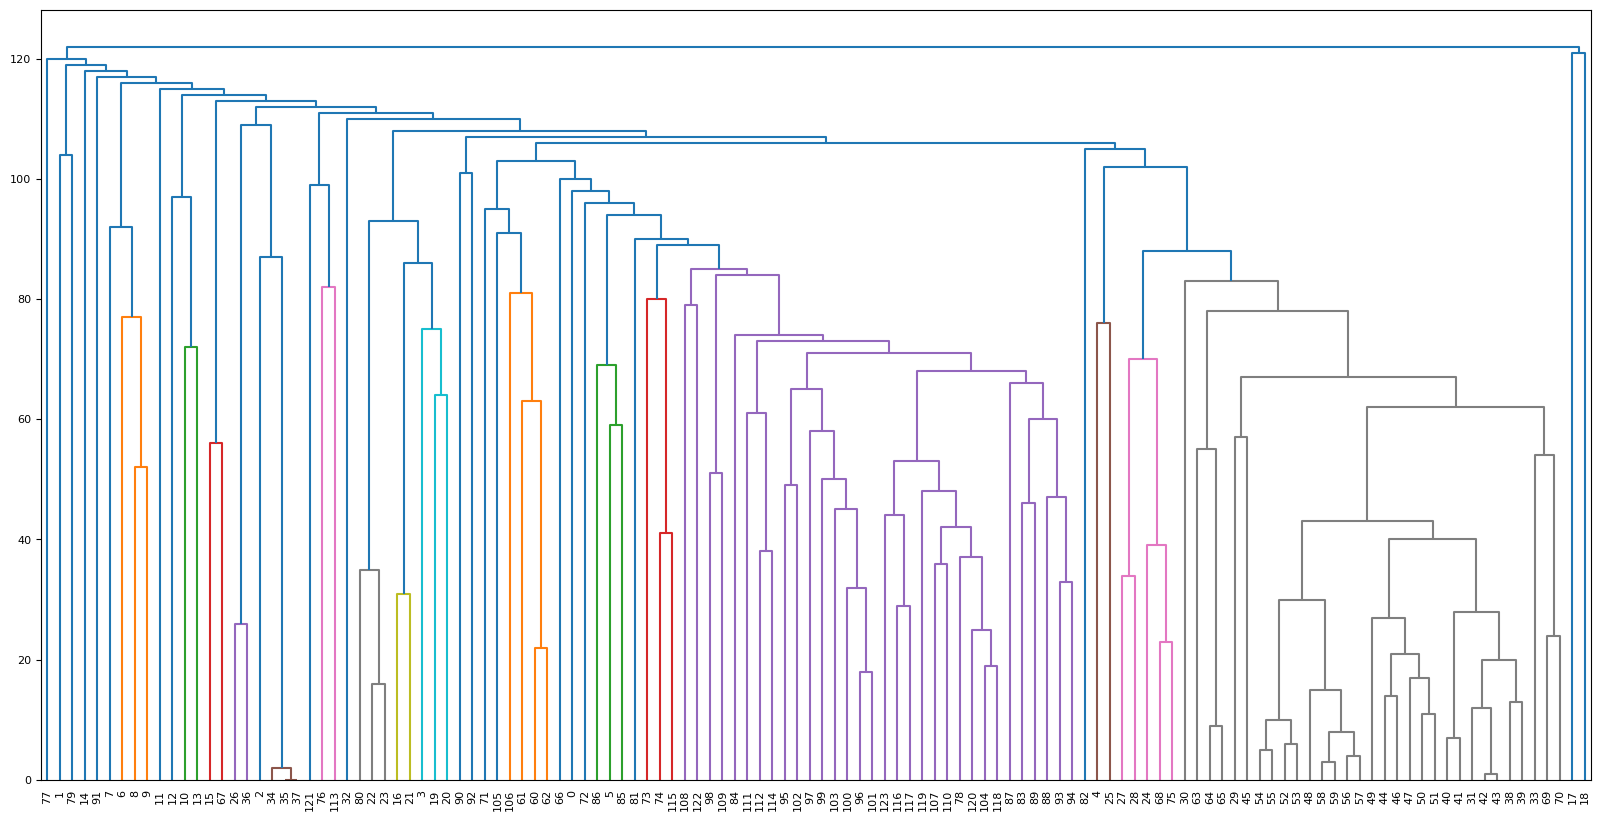

In [30]:
plot_dendrogram_mpl(model, labels=df['preprocessed_text'].index)

In [ ]:
model.labels_